# Imports

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os, yaml
import numpy as np

# Interpretability Metrics and Accuracy

In order to display metrics and accuracy results, we simply load the corresponding `metrics.yaml` file. Results are structured by experiment name (in this case, `vgg19_16`) and distance threshold (in this case 0.1).

In [2]:
results_dir = 'results/vgg19_16'
distance_threshold = 0.1

with open(os.path.join(results_dir, str(distance_threshold), 'metrics.yaml'), "r") as file:
    metrics = yaml.load(file, Loader=yaml.FullLoader)

print(f"AAP - Teacher: {metrics['aap']['teacher']}")
print(f"AAP - KD Student: {metrics['aap']['kd_student']}")
print(f"AAP - Baseline Student: {metrics['aap']['baseline_student']}\n")

print(f"AJS - KD Student: {metrics['ajs']['kd_student']}")
print(f"AJS - Baseline Student: {metrics['ajs']['baseline_student']}\n")

print(f"PMS - KD Student: {metrics['pms']['kd_student']}")
print(f"PMS - Baseline Student: {metrics['pms']['baseline_student']}\n")

print(f"Accuracy - Teacher: {metrics['accuracy']['teacher']}")
print(f"Accuracy - KD Student: {metrics['accuracy']['kd_student']}")
print(f"Accuracy - Baseline Student: {metrics['accuracy']['baseline_student']}")

AAP - Teacher: 6.51415257162582
AAP - KD Student: 8.651536071798413
AAP - Baseline Student: 16.202105626510182

AJS - KD Student: 0.3188239446057044
AJS - Baseline Student: 0.11757595966019906

PMS - KD Student: 0.7480627072542906
PMS - Baseline Student: 0.26342049560546876

Accuracy - Teacher: 0.7623403520883673
Accuracy - KD Student: 0.7317915084570245
Accuracy - Baseline Student: 0.5227821884708319


To compare results across distance thresholds, we load all metrics files. The following corresponds to Figure 1 in our reproducibility report.

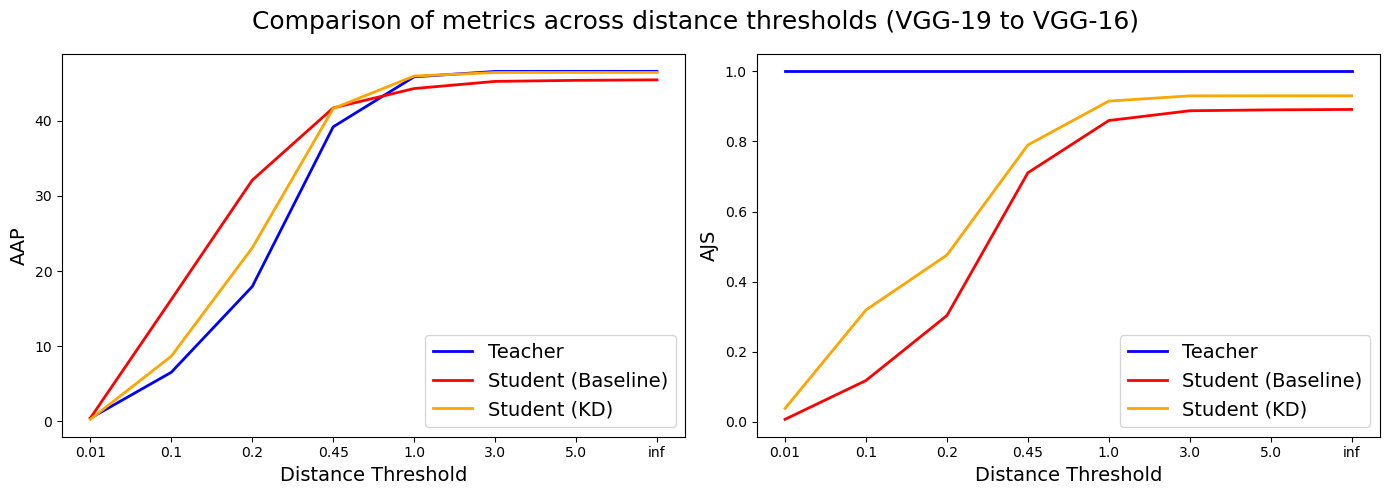

In [3]:
results_dir = 'results/vgg19_16'

AAP_teacher = []
AAP_kd = []
AAP_baseline = []
AJS_kd = []
AJS_baseline = []

distance_thresholds = [0.01, 0.1, 0.2, 0.45, 1.0, 3.0, 5.0, None]
for dt in distance_thresholds:
    with open(os.path.join(results_dir, str(dt), 'metrics.yaml'), "r") as file:
        metrics = yaml.load(file, Loader=yaml.FullLoader)
        AAP_teacher.append(metrics['aap']['teacher'])
        AAP_kd.append(metrics['aap']['kd_student'])
        AAP_baseline.append(metrics['aap']['baseline_student'])
        AJS_kd.append(metrics['ajs']['kd_student'])
        AJS_baseline.append(metrics['ajs']['baseline_student'])
distance_thresholds[-1] = 'inf'

f, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(distance_thresholds, AAP_teacher, label='Teacher', color='blue', linewidth=2)
axes[0].plot(distance_thresholds, AAP_baseline, label='Student (Baseline)', color='red', linewidth=2)
axes[0].plot(distance_thresholds, AAP_kd, label='Student (KD)', color='orange', linewidth=2)
axes[0].set_xlabel('Distance Threshold', fontsize=14)
axes[0].set_ylabel('AAP', fontsize=14)
axes[0].legend(loc='lower right', fontsize=14)
axes[1].plot(distance_thresholds, [1]*len(distance_thresholds), label='Teacher', color='blue', linewidth=2)
axes[1].plot(distance_thresholds, AJS_baseline, label='Student (Baseline)', color='red', linewidth=2)
axes[1].plot(distance_thresholds, AJS_kd, label='Student (KD)', color='orange', linewidth=2)
axes[1].set_xlabel('Distance Threshold', fontsize=14)
axes[1].set_ylabel('AJS', fontsize=14)
axes[1].legend(loc='lower right', fontsize=14)
plt.suptitle('Comparison of metrics across distance thresholds (VGG-19 to VGG-16)', fontsize=18)
plt.tight_layout()
plt.show()


# Prototype Comparison

To compare the prototypes of teacher and student networks, we display the nearest training patches for each of them. Folder `./nearest/` contains a subfolder for each network. In each of these, a total of 2000 subfolders exist (one for each prototype), each with the (ordered) nearest training patches to the corresponding prototype.

Here, we select a random subset of teacher prototypes and visualize them in the first row. In order to obtain the corresponding prototypes from the student network, we load the allocations obtained during computation of PMS score. These are the allocations obtained through Hungarian Matching algorithm, as explained in Proto2Proto.

This code was used for Figure 2, 4, and 5 in our reproducibility study.

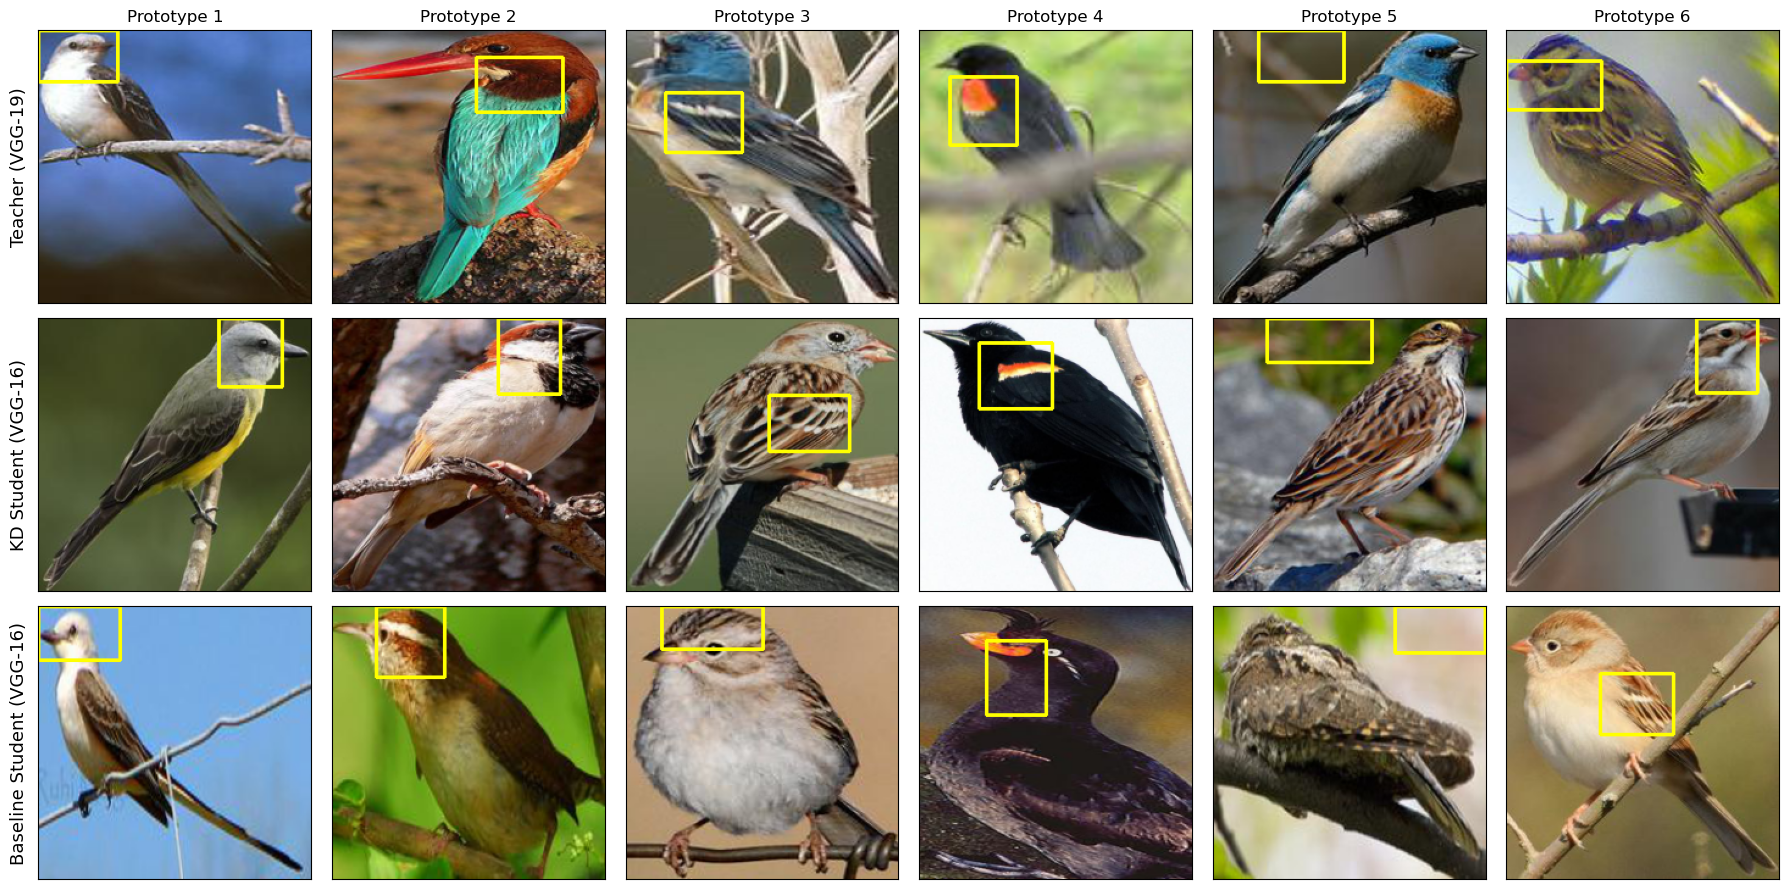

In [6]:
teacher_img_folder = 'nearest/vgg19_teacher/'
kd_student_img_folder = 'nearest/vgg16_kd/'
baseline_student_img_folder = 'nearest/vgg16_baseline/'

# Select random teacher prototypes and corresponding student prototypes (matched through Hungarian Matching algorithm)
selection  = np.random.choice(range(2000), 6)
kd_allocation = np.load('results/vgg19_16/kd_best_allocation.npy')[1]
baseline_allocation = np.load('results/vgg19_16/baseline_best_allocation.npy')[1]

teacher_prototypes = selection
kd_student_prototypes = [kd_allocation[i] for i in selection]
baseline_student_prototypes = [baseline_allocation[i] for i in selection]

num_images = len(teacher_prototypes)

f, axes = plt.subplots(3, num_images, figsize=(num_images * 3, 9))
for i, p in enumerate(teacher_prototypes):
    img = Image.open(os.path.join(teacher_img_folder, f'{p:05d}', '01.png'))
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Prototype {i+1}')
    axes[0, i].set_ylabel('Teacher (VGG-19)', fontsize=13) if i == 0 else None
    axes[0, i].get_xaxis().set_visible(False)
    axes[0, i].get_yaxis().set_ticks([])
for i, p in enumerate(kd_student_prototypes):
    img = Image.open(os.path.join(kd_student_img_folder, f'{p:05d}', '01.png'))
    axes[1, i].imshow(img)
    axes[1, i].set_ylabel('KD Student (VGG-16)', fontsize=13) if i == 0 else None
    axes[1, i].get_xaxis().set_visible(False)
    axes[1, i].get_yaxis().set_ticks([])
for i, p in enumerate(baseline_student_prototypes):
    img = Image.open(os.path.join(baseline_student_img_folder, f'{p:05d}', '01.png'))
    axes[2, i].imshow(img)
    axes[2, i].set_ylabel('Baseline Student (VGG-16)', fontsize=13) if i == 0 else None
    axes[2, i].get_xaxis().set_visible(False)
    axes[2, i].get_yaxis().set_ticks([])
plt.tight_layout()
plt.show()